# ENGG 192 

-----

### Dartmouth College - January 20, 2019
### Spencer Bertsch
This program uses PyTorch to create a dense, feedforward neural networks designed to predict the results of NBA games betoween 2014 and 2018.  

The next Assignment (1b) will entail a notebook which studies several regularization techniques such as hyperparameter optimization techniques, techniques to limit the effects of overfitting such as early stopping and dropout layers, and will discuss other methods and theiries currently used to improve the performance of funtional, applied deep learning models. 

The data source for this project can be found [here](https://www.kaggle.com/ionaskel/nba-games-stats-from-2014-to-2018#nba.games.stats.csv). 



In [3]:
# Deep learning 
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable #<-- Variable can be thought of as a Torch matrix
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import time
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

#Data cleaning and preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

#Model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import f1_score


## Load the Dataset 

Our dataset exists as a .csv file downloaded form Kaggle. In a more developed project we could develop the way that data is loaded into this notebook, but for now we can simply use a handy feature of Pandas called 'read_csv' to import a .csv to a pandas dataframe. 

In [4]:
# Import the dataset - load .csv file
path = '/Users/spencerbertsch/Desktop/ENGG 192/Dense_NNs/Data/nba_raw_data.csv'
#create a dataframe from the NBA data stored in the .csv file
NBA_data_raw = pd.read_csv(path)

print("Shapw of raw dataset:", (NBA_data_raw.shape))
print("So we can see that we have 40 features and one label vector")
print("We can also see that we have 9,840 rows")
print(" ")
print("We can also preview our dataset by observing the top five rows")
NBA_data_raw.head(5)

Shapw of raw dataset: (9840, 41)
So we can see that we have 40 features and one label vector
We can also see that we have 9,840 rows
 
We can also preview our dataset by observing the top five rows


,Unnamed: 0,Team,Game,Date,Home,Opponent,WINorLOSS,TeamPoints,OpponentPoints,FieldGoals,...,Opp.FreeThrows,Opp.FreeThrowsAttempted,Opp.FreeThrows.,Opp.OffRebounds,Opp.TotalRebounds,Opp.Assists,Opp.Steals,Opp.Blocks,Opp.Turnovers,Opp.TotalFouls
0,1,ATL,1,10/29/14,Away,TOR,L,102,109,40,...,27,33,0.818,16,48,26,13,9,9,22
1,2,ATL,2,11/1/14,Home,IND,W,102,92,35,...,18,21,0.857,11,44,25,5,5,18,26
2,3,ATL,3,11/5/14,Away,SAS,L,92,94,38,...,27,38,0.711,11,50,25,7,9,19,15
3,4,ATL,4,11/7/14,Away,CHO,L,119,122,43,...,20,27,0.741,11,51,31,6,7,19,30
4,5,ATL,5,11/8/14,Home,NYK,W,103,96,33,...,8,11,0.727,13,44,26,2,6,15,29


In [5]:
print(" ")
print("We can then make a list from the column headers and observe all of the information that our dataset has aggregated for each game")
cols = list(NBA_data_raw.columns.values) #Make a list of all of the columns in the df
cols

 
We can then make a list from the column headers and observe all of the information that our dataset has aggregated for each game


['Unnamed: 0',
 'Team',
 'Game',
 'Date',
 'Home',
 'Opponent',
 'WINorLOSS',
 'TeamPoints',
 'OpponentPoints',
 'FieldGoals',
 'FieldGoalsAttempted',
 'FieldGoals.',
 'X3PointShots',
 'X3PointShotsAttempted',
 'X3PointShots.',
 'FreeThrows',
 'FreeThrowsAttempted',
 'FreeThrows.',
 'OffRebounds',
 'TotalRebounds',
 'Assists',
 'Steals',
 'Blocks',
 'Turnovers',
 'TotalFouls',
 'Opp.FieldGoals',
 'Opp.FieldGoalsAttempted',
 'Opp.FieldGoals.',
 'Opp.3PointShots',
 'Opp.3PointShotsAttempted',
 'Opp.3PointShots.',
 'Opp.FreeThrows',
 'Opp.FreeThrowsAttempted',
 'Opp.FreeThrows.',
 'Opp.OffRebounds',
 'Opp.TotalRebounds',
 'Opp.Assists',
 'Opp.Steals',
 'Opp.Blocks',
 'Opp.Turnovers',
 'Opp.TotalFouls']

## Data Cleaning

We can see that our target vector (Win or Loss) is the seventh column from the left, so the first thing we need to do is move that vector to the end (right side) of the dataframe. 

The next thing we can see is that several of these feature vectors in addition to our label vector contain categorical data in the form of strings. The general way to deal with categorical data is to encode this data into numeric data - this will allow our dense neural netowrk to learn from this data. 

After our features are seperated from the label and we have purely numeric data, we can scale our dataset and we will be ready for training! 

In [6]:
#move label vector to the end of the dataframe 

cols = list(NBA_data_raw.columns.values) #Make a list of all of the columns in the df
cols.pop(cols.index('WINorLOSS')) #Remove WINorLOSS from list
df = NBA_data_raw[cols+['WINorLOSS']] #Create new dataframe with columns in the order you want
df.head(5) 

,Unnamed: 0,Team,Game,Date,Home,Opponent,TeamPoints,OpponentPoints,FieldGoals,FieldGoalsAttempted,...,Opp.FreeThrowsAttempted,Opp.FreeThrows.,Opp.OffRebounds,Opp.TotalRebounds,Opp.Assists,Opp.Steals,Opp.Blocks,Opp.Turnovers,Opp.TotalFouls,WINorLOSS
0,1,ATL,1,10/29/14,Away,TOR,102,109,40,80,...,33,0.818,16,48,26,13,9,9,22,L
1,2,ATL,2,11/1/14,Home,IND,102,92,35,69,...,21,0.857,11,44,25,5,5,18,26,W
2,3,ATL,3,11/5/14,Away,SAS,92,94,38,92,...,38,0.711,11,50,25,7,9,19,15,L
3,4,ATL,4,11/7/14,Away,CHO,119,122,43,93,...,27,0.741,11,51,31,6,7,19,30,L
4,5,ATL,5,11/8/14,Home,NYK,103,96,33,81,...,11,0.727,13,44,26,2,6,15,29,W


### Continued data cleaning

We can see that our label vector has been moved to the end of the dataframe. We can now encode our categorical data so that we have a purely numeric dataset. 

In [7]:
#define a function to label encode a 2D (x,y) matrix and return an encoded matrix
def int_encode(df):
    cols = df.shape[1]
    rows = df.shape[0]
    original_size = df.shape[1]
    
    for i in range(0, cols, 1):
        values = df.iloc[:,i]
        #integer encode each column
        label_encoder = LabelEncoder()
        integer_encoded = label_encoder.fit_transform(values) #integer encode the i'th column 
        encoded_vec = pd.DataFrame(integer_encoded) #convert to pd.dataframe
        df = pd.concat([df, encoded_vec], axis=1) #concatenate the new, encoded vector onto the original dataframe
    
    final_df = df.iloc[:,-cols:] #Only keep the last (leftmost) half of the columns representing the encoded data
    print("Integer encoding successful!")
    print("Dataframe shape: ", final_df.shape)
    return(final_df)


We can now use our function to convert our categorical data into integer encoded, numeric data. 

In [8]:
df2 = int_encode(df)
df2.head(5) #preview our new dataset

Integer encoding successful!
Dataframe shape:  (9840, 41)


,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,143,0,27,37,44,21,19,...,32,210,16,27,20,13,9,7,15,0
1,1,0,1,155,1,11,37,27,16,8,...,20,231,11,23,19,5,5,16,19,1
2,2,0,2,251,0,26,27,29,19,31,...,37,145,11,29,19,7,9,17,8,0
3,3,0,3,259,0,4,54,57,24,32,...,26,163,11,30,25,6,7,17,23,0
4,4,0,4,263,1,19,38,31,14,20,...,10,154,13,23,20,2,6,13,22,1


The last step in preprocessing is to scale our dataset. 

In [9]:
#Scaling
df_scaled = preprocessing.scale(df2)
print(df_scaled[:,5:]) #print first 5 rows of the new numpy matrix

[[ 1.44417822 -0.13558717  0.43892343 ... -1.19881172  0.4498342
  -1.        ]
 [-0.4043699  -0.13558717 -0.9563166  ...  1.12716247  1.37653127
   1.        ]
 [ 1.32864396 -0.9563166  -0.79217071 ...  1.38560405 -1.17188567
  -1.        ]
 ...
 [-1.67524673 -0.54595188 -0.05351423 ...  1.12716247  0.4498342
  -1.        ]
 [-1.55971247  0.7672152  -0.21766011 ...  0.61027932 -0.47686287
   1.        ]
 [ 0.75097267 -0.9563166  -0.21766011 ...  0.61027932  1.60820554
  -1.        ]]


In [10]:
#Seperate training and testing data
y = df2.iloc[:, -1] #labels are the last column in the matrix
X = df2.iloc[:, :40] #assign feature set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
print("X train shape: ", X_train.shape)
print("y train shape: ", y_train.shape)
print("X test shape: ", X_test.shape)
print("y test shape: ", y_test.shape) 

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values 
y_test = y_test.values

X train shape:  (6888, 40)
y train shape:  (6888,)
X test shape:  (2952, 40)
y test shape:  (2952,)


And with that, we have fully prepared our dataset! Remember that the 41st column - the label vector - represents the result of the game. This is what we're trying to predict. We're now ready to create a neural network in TensorFlow and begin training.

# Deep Learning - PyTorch

------

### SOURCES

When learning how to construct feedforward networks (or any type of netowrk) in PyTorch, I referenced [Sung Kim's Github](https://github.com/hunkim). There, Sung Kim has layed out a repository called [PyTorch Zero To All](https://github.com/hunkim/PyTorchZeroToAll) in which he includes slide decks and code explaining how to build neural netowrks using pytorch from first principles. This was my main resource - in addition to Sung Kim's [Youtube Series](https://www.youtube.com/watch?v=SKq-pmkekTk) - which I used for the next section of this notebook. 

Other important sources include: 

"Deep Learning" by Ian Goodfellow and Yoshua Bengio and Aaron Courville. 

@book{Goodfellow-et-al-2016, <br>
    title={Deep Learning}, <br>
    author={Ian Goodfellow and Yoshua Bengio and Aaron Courville}, <br>
    publisher={MIT Press}, <br>
    note={\url{http://www.deeplearningbook.org}}, <br>
    year={2016} <br>
}




In [11]:
class NBA_Net(nn.Module):
    def __init__(self):
        """
        "super can be used to refer to parent classes without naming them explicitly"
        
        We can now construct the network using torch.nn.linear layers 
        """
        super().__init__()
        self.l1 = torch.nn.Linear(40, 20)
        self.dropout = nn.Dropout(0.5)
        self.l2 = torch.nn.Linear(20, 10)
        self.l3 = torch.nn.Linear(10, 1)

        self.sigmoid = torch.nn.Sigmoid()
        
        
    def forward(self, x):
        """
        Our forward function takes in the input data and uses the sigmoid activation function to generate the output
        """
        
        out1 = self.sigmoid(self.l1(x))
        out2 = self.sigmoid(self.l2(out1))
        y_pred = self.sigmoid(self.l3(out2))
        return y_pred
        

## A quick note on regularization techniques

Note that one dropout layer with p=0.5 was used between the first and secodn layer of the network. There is no generally accepted way to introduce specific regularization techniques to boost model performance or limit the negative effects of overfitting other than simple experementation and testing. James Bergstra and Yoshua Bengio outline this well in their 2012 paper, [Random Search for Hyper-Parameter Optimization](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf) in which they discuess optimization of several hyperpapameters used in deep learning such as network topology (number of layers and neurons per layer) and learning rate. They conclude it's best to use a random search method as opposed to grid search when finding the correct hyperparameters which will yeild the best results from a network. 

This topic will be further discussed in a later notebook when I focus exclusively on regularization techniques. 

In [12]:
# Define Learning Parameters

model = NBA_Net() #<-- Use the model created above 
#We use mean squared error as our loss function becasue the problem at hand is very simple 
loss_fn = nn.BCELoss()
#Adam is a very strong genric optimizer, so we can use it here
optimizer = optim.Adam(model.parameters(), lr=1e-3)

training_epochs = 500
minibatch_size = 10

We are now ready to train our network. Simple guess and check was used to arrive at the parameter values above. In the next notebook, I will explore the ways that Regularization texhniques can be used to improve model performance. 

In [13]:
t0 = time.clock()#define t0 so we can measure training time for different network variations

for i in range(training_epochs):
    print("Epoch", i+1, "/", training_epochs)
    
    for batch_ind in range(4):
        # wrap the data in variables
        minibatch_state_var = Variable(torch.Tensor(X_train))
        minibatch_label_var = Variable(torch.Tensor(y_train))
        
        # forward pass
        y_pred = model(minibatch_state_var)
        
        # loss is MSE - defined above 
        # compute loss as the difference between the prediction and the true label 
        loss = loss_fn(y_pred, minibatch_label_var)

        # now that the forward pass is done, we need to reset all gradients
        optimizer.zero_grad()
        
        # backwards pass
        loss.backward()
        
        # step the optimizer - update the weights
        optimizer.step()
        
print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ")     
print("TRAINING COMPLETE")
print("Number of Epochs Trained: ", training_epochs)
print("With minibatch size: ", minibatch_size)
print("Training time: ", time.clock()) 
print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ")

Epoch 1 / 500
Epoch 2 / 500
Epoch 3 / 500
Epoch 4 / 500
Epoch 5 / 500
Epoch 6 / 500
Epoch 7 / 500
Epoch 8 / 500
Epoch 9 / 500
Epoch 10 / 500
Epoch 11 / 500
Epoch 12 / 500
Epoch 13 / 500
Epoch 14 / 500
Epoch 15 / 500
Epoch 16 / 500
Epoch 17 / 500
Epoch 18 / 500
Epoch 19 / 500
Epoch 20 / 500
Epoch 21 / 500
Epoch 22 / 500
Epoch 23 / 500
Epoch 24 / 500
Epoch 25 / 500
Epoch 26 / 500
Epoch 27 / 500
Epoch 28 / 500
Epoch 29 / 500
Epoch 30 / 500
Epoch 31 / 500
Epoch 32 / 500
Epoch 33 / 500
Epoch 34 / 500
Epoch 35 / 500
Epoch 36 / 500
Epoch 37 / 500
Epoch 38 / 500
Epoch 39 / 500
Epoch 40 / 500
Epoch 41 / 500
Epoch 42 / 500
Epoch 43 / 500
Epoch 44 / 500
Epoch 45 / 500
Epoch 46 / 500
Epoch 47 / 500
Epoch 48 / 500
Epoch 49 / 500
Epoch 50 / 500
Epoch 51 / 500
Epoch 52 / 500
Epoch 53 / 500
Epoch 54 / 500
Epoch 55 / 500
Epoch 56 / 500
Epoch 57 / 500
Epoch 58 / 500
Epoch 59 / 500
Epoch 60 / 500
Epoch 61 / 500
Epoch 62 / 500
Epoch 63 / 500
Epoch 64 / 500
Epoch 65 / 500
Epoch 66 / 500
Epoch 67 / 500
Epoc

/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([6888])) that is different to the input size (torch.Size([6888, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


In [19]:
#Test the trained model with our holdout data "X_test"
input_1 = Variable(torch.Tensor(X_test)) # "variable" simply creates a new tenosr
input_1

#Make predictions on the inputs 
pred_1 = model(input_1)
print("Prediction for the 1st inputs:") 
pred_1

Prediction for the 1st inputs:


tensor([[0.0027],
        [0.0043],
        [0.0024],
        ...,
        [0.9942],
        [0.9942],
        [0.9942]], grad_fn=<SigmoidBackward>)

# Model Evaluation

------

Now that our network has been trained and we have predicted the results using our testing data, we can determine the model's performance. We know that the label veoctor is fairly well balanced, so using Accuracy as a performance metric makes sense here. I will also use both F1 Score and the ROC Score to make sure the results of testing hold up under different XXX. Lastly, and arguable most importantly, we will examine the confusion matrix to determine the rates of Type I and Type II error. 

We know that $Accuracy = [(TP + TN)/(TP + TN + FP + FN)]$, and becasue our label vector is well balanced with a ratio of (XX/YY), we know accuracy will yeild a strong performance metric. However, it's important to make sure the error is not shifted too far to one side, so we use the F1 Score as well. 

Remember that $F1 Score = 2 [(Precision*Recall)/(Precision + Recall)]$ 

where $Precision = [True Positive/(True Positive + False Positive)]$, in other words, $Precision = [True Positive/Total Predicted Positive]$

and $Recall = [True Positive/(True Positive + False Negative)]$, in other words, $Precision = [True Positive/Total Actual Positive]$

Source: [Towards Data Science](https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9)

Perhaps most telling will be the confusion matrix, which will gave us the number of true and false predictions on both the "prediction" and "actual" side. 

In [16]:
#Lets see how we did! 
pred_1_np = pred_1.detach().numpy()
y_pred = np.where(pred_1_np>0.5,1,0) #Convert to binary 
y_true = y_test
A = accuracy_score(y_true, y_pred)
F1 = f1_score(y_true, y_pred)
print("Accuracy:", A)
print("F1 Score:", F1)

Accuracy: 0.9939024390243902
F1 Score: 0.9938482570061516


ROC Score:  0.994


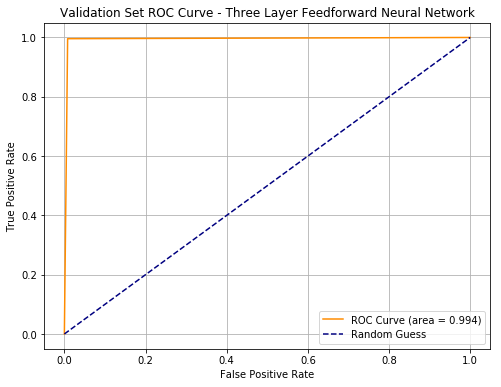

In [17]:
# ROC SCORE - PLOT 
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_true, y_pred)
area1 = metrics.auc(fpr1, tpr1)
area1 = str(round(area1, 3))
print("ROC Score: ", area1)

x = range(1)
y = range(1)
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

plt.plot(fpr1, tpr1, color='darkorange', label=('ROC Curve (area = ' + area1 + ')')) 
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label=('Random Guess'))
plt.legend(loc='lower right');
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation Set ROC Curve - Three Layer Feedforward Neural Network')
plt.grid()

In [18]:
confusion_matrix(y_true, y_pred)

array([[1480,   12],
       [   6, 1454]])

Our model performed very well, with an F1 Score of 99.38%, Accuracy of 99.39%, and an ROC Score of ~99.4%. 

Before we jump to our feet and run to the sports betting websites, we have to realize that the features in our dataset contain data from the games that we are trying to predict. In other words, we would have to wait through the entire game to collect and aggreagate the data from the game before cleaning it and feeding it to our dense, fully connected network. 

Unless we could do this very efficiently (instantly..) there is little use for this program in terms of actual sports betting. Still, it was a good way to practice using PyTorch to construct a feedforward neural netowrk and perform simple regularization techniques to improve model performance.